# **USA Cars Dataset: EDA and Model Implementation**

In this kernel, we will first explore the data and try to understand the relationships among variables. Then build a couple of machine learning models to predict the price of cars using the features provided in the dataset.

Let's begin...

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("../input/usa-cers-dataset/USA_cars_datasets.csv")
df.head()

,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


In [3]:
df.shape

(2499, 13)

The dataset includes 13 features of 2499 cars. Some of the features are important when determining the price of a car while some are redundant. For example, “vin”, “lot” and “Unnamed: 0” columns have no effect on the price. These three columns represent kind of an ID for a car. Since the dataset is taken from a website in US, I think the country column only includes “usa”. Let’s check:

In [4]:
df.country.value_counts()

 usa       2492
 canada       7
Name: country, dtype: int64

Not all but overwhelming majority is “usa” so there is no point in using “country” column as a feature in our model. So the columns that we will not use in the model are "Unnamed, vin, lot, country" so lets drop them.

In [5]:
df.drop(['Unnamed: 0','vin', 'lot','country'], axis=1, inplace=True)
df.head()

,price,brand,model,year,title_status,mileage,color,state,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,new jersey,10 days left
1,2899,ford,se,2011,clean vehicle,190552.0,silver,tennessee,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,georgia,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,virginia,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,florida,22 hours left


In [6]:
#missing values
df.isna().sum().sum()

0

In [7]:
df.dtypes

price             int64
brand            object
model            object
year              int64
title_status     object
mileage         float64
color            object
state            object
condition        object
dtype: object

There is no missing value in the dataset and the datatypes seem appropriate.

Let's start exploring the data.

I always start with checking the target variable. Target variable is what we struggle to predict. At the end of the way, we will evaluate the model based on how close our predictions are to the target. So knowing the target variable well is a good practice. Let’s check the distribution of the target variable. We first need to import data visualization libraries that we will use during EDA process.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# **Target Variable**

Text(0.5, 1.0, 'Distribution of Car Prices')

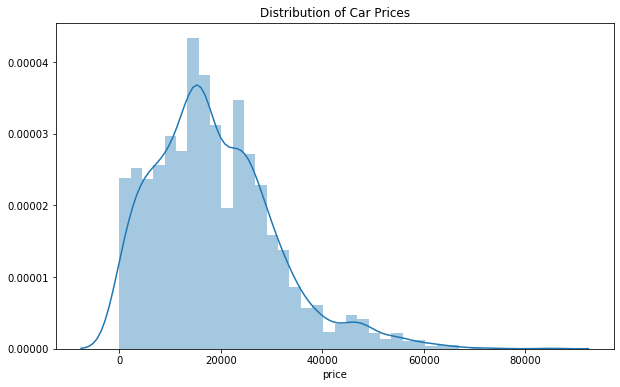

In [9]:
plt.figure(figsize=(10,6))

sns.distplot(df['price']).set_title('Distribution of Car Prices')

The price variable is not normally distributed. It is right-skewed meaning the tail of the distribution is longer on the right side than on the left side. Another way to prove skewness is comparing mean and median. If mean is higher than the median, the distribution is right-skewed. Mean is the average value and median is the value in the middle. So if mean is higher than the median, we have more samples on the upper side of the median.

In [10]:
print("Mean value of prices {}".format(df.price.mean()))
print("Median value of prices {}".format(df.price.median()))

Mean value of prices 18767.671468587436
Median value of prices 16900.0


Mean is higher than median, as expected. So, there are more of expensive cars than of cheaper cars.

# **Brand and Model**

In [11]:
df.brand.value_counts().size

28

In [12]:
df.brand.value_counts()[:6].values.sum() / len(df)

0.9395758303321329

There are 28 different brands in the dataset but almost 94% of the cars belong to six brands. Remaining 6% are distributed among 22 different brands. We can mark these 22 brands as other. We first create a list that includes these 22 brands and then use pandas replace function on “brand” column.

In [13]:
other = df.brand.value_counts().index[6:]
len(other)

22

In [14]:
df.brand = df.brand.replace(other, 'other')

In [15]:
df.brand.value_counts()

ford         1235
dodge         432
nissan        312
chevrolet     297
other         151
gmc            42
jeep           30
Name: brand, dtype: int64

It is time to check if how price changes according to different brands. Boxplot is an informative tool for this task. We can also use pandas groupby function to check average prices of each brand

In [16]:
df[['price','brand']].groupby('brand').mean().sort_values(by='price', ascending=False)

,price
brand,
ford,21666.888259
chevrolet,18669.952862
dodge,17781.988426
other,15727.470199
nissan,12065.820513
jeep,10933.833333
gmc,10657.380952


Text(0.5, 1.0, 'Price Distribution of Different Brands')

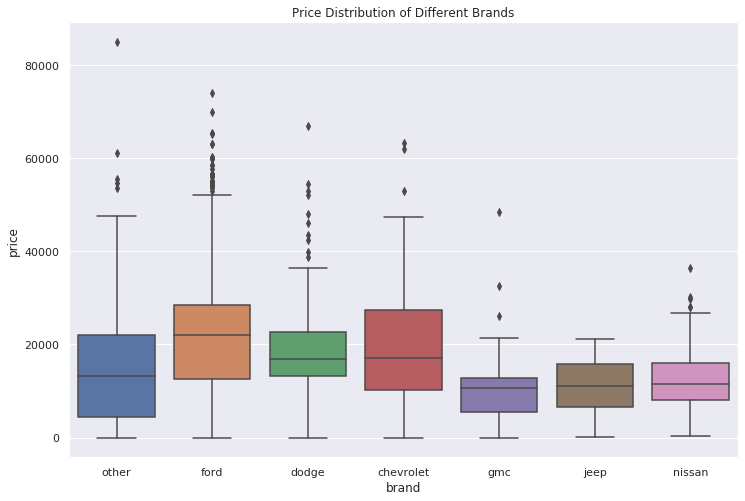

In [17]:
plt.figure(figsize=(12,8))

sns.set(style='darkgrid')
sns.boxplot(x='brand', y='price', data=df).set_title("Price Distribution of Different Brands")

The line in the boxes shows the average price. Ford cars have the highest average price but please keep in mind that almost half of the cars in the dataset are ford. It might be useful when building and evaluating our model. There are also some extreme values (i.e. outliers) represented with block dots. We will handle outliers later on. The height of the boxplots represent how spread out the values are. The dataset includes more dodge cars than chevrolet cars but price of chevrolet cars are more spread out than dodge cars. Variety of models might be causing this spread out. Let’s check how many models each brand has:

In [18]:
df[['brand','model']].groupby('brand').nunique()

,brand,model
brand,,
chevrolet,1,28
dodge,1,13
ford,1,40
gmc,1,7
jeep,1,4
nissan,1,23
other,1,43


Although there are more dodge cars than chevrolet cars, number of models of chevrolet is more than double of dodge which I think explains the difference in price range. Let’s again use boxplot to see price distribution depending on models taking "Dodge" brand as an example:

Text(0.5, 1.0, 'Prices of Different Dodge Models')

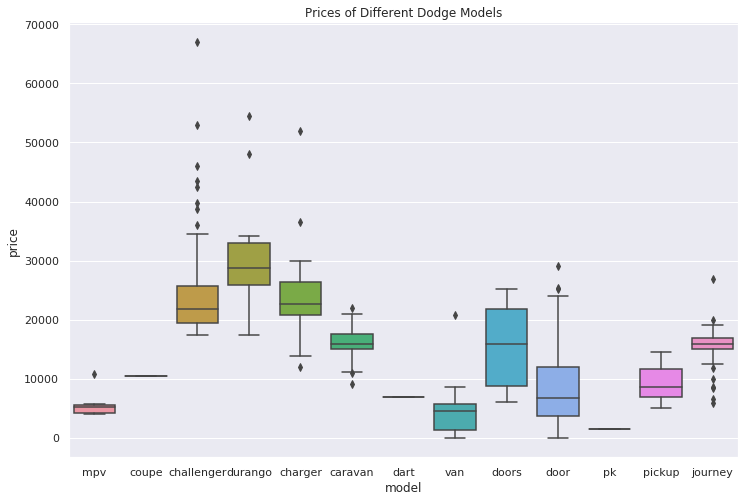

In [19]:
plt.figure(figsize=(12,8))

sns.set(style='darkgrid')
sns.boxplot(x='model', y='price', data=df[df.brand == 'dodge']).\
            set_title('Prices of Different Dodge Models')

Price range significantly changes depending on model.

Let's check how many models we have.

In [20]:
df.model.value_counts().size

127

In [21]:
df.model.value_counts()[:50].sum() / len(df)

0.938375350140056

There are 127 models in the entire dataset but 50 models cover almost 94% of cars so we can mark the remaining models as other.

In [22]:
other_models = df.model.value_counts().index[50:]
len(other_models)

77

In [23]:
df.model = df.model.replace(other_models, 'other_models')

In [24]:
df.head()

,price,brand,model,year,title_status,mileage,color,state,condition
0,6300,other,other_models,2008,clean vehicle,274117.0,black,new jersey,10 days left
1,2899,ford,other_models,2011,clean vehicle,190552.0,silver,tennessee,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,georgia,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,virginia,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,florida,22 hours left


# **Title Status**

Title status indicates whether a car is clean or salvage which is definitely a factor in determining the price. Let’s confirm:

In [25]:
df[['price','title_status']].groupby('title_status').agg(['mean','count'])

price      
                           mean count
title_status                         
clean vehicle      19914.439640  2336
salvage insurance   2333.006135   163

We do not have many salvage cars in the dataset but it is a must-have feature with the remarkable price difference.

# **Color**

In [26]:
df.color.value_counts().size

49

In [27]:
df.color.value_counts()[:6].sum() / len(df)

0.9047619047619048

There are 49 different colors but 90% of cars belong to 6 different colors. We can mark the remaining colors as other like we did in “brand” column.

In [28]:
other_colors = df.color.value_counts().index[6:]
len(other_colors)

43

In [29]:
df.color = df.color.replace(other_colors, 'other_colors')

In [30]:
df.color.value_counts()

white           707
black           516
gray            395
silver          300
other_colors    238
red             192
blue            151
Name: color, dtype: int64

Let's check the effect of color on price using boxplots.

Text(0.5, 1.0, 'Color vs Price')

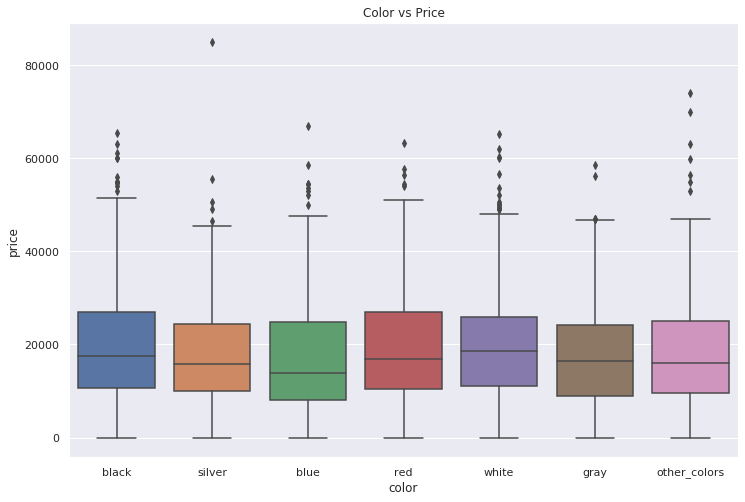

In [31]:
sns.set(style='darkgrid')
plt.figure(figsize=(12,8))
sns.boxplot(x='color', y='price', data=df).set_title("Color vs Price")

The image above tells us two important things:

* Color is not a decisive factor for price. The mean and the amount of spread of price are not changing much for different colors. Thus, it is better not to include “color” as a feature in our model.

* There are outliers and we somehow need to handle them. Otherwise, the model will try to capture them which prevents the model from generalizing well to the dataset.

We have some cars that have extremely high prices. These outliers are not grouped in a particular color. From the figure above, it seems like all of the outliers are above 45000. Let’s check how many outliers we have and decide if we can afford to drop them.

In [32]:
len(df[df.price > 45000]) 

102

In [33]:
len(df[df.price > 45000]) / len(df)

0.04081632653061224

There are 102 cars above 45000 which makes up 4% of entire dataset. I think we can drop these samples. In some cases, 4% is too much to drop so it is up to you to decide how to mark and handle outliers. There is not a strict definition of outliers.

In [34]:
df = df[df.price < 45000]
len(df)

2394

Text(0.5, 1.0, 'Price Distribution Without Outliers')

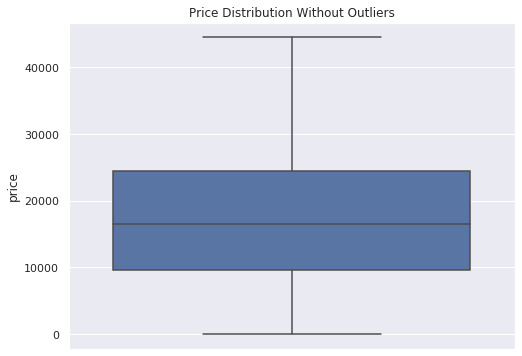

In [35]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,6))
sns.boxplot(y='price', data=df).set_title("Price Distribution Without Outliers")

# **Year and Mileage**

Year and mileage definitely changes the price of car so we will use these features in the model. I prefer to convert the “year” column to “age” by substracting it from the current year.

In [36]:
age = 2020 - df.iloc[:,3].values

In [37]:
df['age'] = age

In [38]:
df = df.drop(['year'], axis=1)

In [39]:
df.head()

,price,brand,model,title_status,mileage,color,state,condition,age
0,6300,other,other_models,clean vehicle,274117.0,black,new jersey,10 days left,12
1,2899,ford,other_models,clean vehicle,190552.0,silver,tennessee,6 days left,9
2,5350,dodge,mpv,clean vehicle,39590.0,silver,georgia,2 days left,2
3,25000,ford,door,clean vehicle,64146.0,blue,virginia,22 hours left,6
4,27700,chevrolet,1500,clean vehicle,6654.0,red,florida,22 hours left,2


# **Condition**

Condition indicates time to the end of auction which I think may increase the demand and thus the price. However, we cannot use it in its current format. We should represent it with a proper data type which is integer showing number of minutes.

There are many way to do this task. Feel free to try different methods. I will do it as follows:

1. Split condition column on spaces and expand to a new dataframe with three columns (e.g. 10 — days — left)
2. Convert the second column to appropriate minutes values (e.g. replace days with 1440, hours with 60)
3. Then multiply first column with the second column to get remaining time to auction end in minutes.

**Note:** There are some rows in condition column with “Listing Expired”. For those rows, I will replace “Expired” with 0 and “Listing” with 1 so that the remaining time becomes zero.

In [40]:
df_condition = df.condition.str.split(' ', expand=True)
df_condition.head()

,0,1,2
0,10,days,left
1,6,days,left
2,2,days,left
3,22,hours,left
4,22,hours,left


In [41]:
a = {'days':1440, 'hours':60, 'minutes':1, 'Expired':0}

df_condition[1] = df_condition[1].replace(a)
df_condition[0] = df_condition[0].replace('Listing',1)

#convert to numeric and multiply
df_condition[0] = pd.to_numeric(df_condition[0]) 
df_condition['time'] = df_condition[0] * df_condition[1]

#create a new column in the original dataframe
df['time_left'] = df_condition['time']

In [42]:
df.head()

,price,brand,model,title_status,mileage,color,state,condition,age,time_left
0,6300,other,other_models,clean vehicle,274117.0,black,new jersey,10 days left,12,14400
1,2899,ford,other_models,clean vehicle,190552.0,silver,tennessee,6 days left,9,8640
2,5350,dodge,mpv,clean vehicle,39590.0,silver,georgia,2 days left,2,2880
3,25000,ford,door,clean vehicle,64146.0,blue,virginia,22 hours left,6,1320
4,27700,chevrolet,1500,clean vehicle,6654.0,red,florida,22 hours left,2,1320


# **Correlation Matrix**

Another useful tool in EDA process is correlation matrix which can be used to find the correlations among continuous features. The **corr()** method can be applied on dataframe and the results can also be visualized using a **heatmap**.

Text(0.5, 1, 'Correlation Matrix')

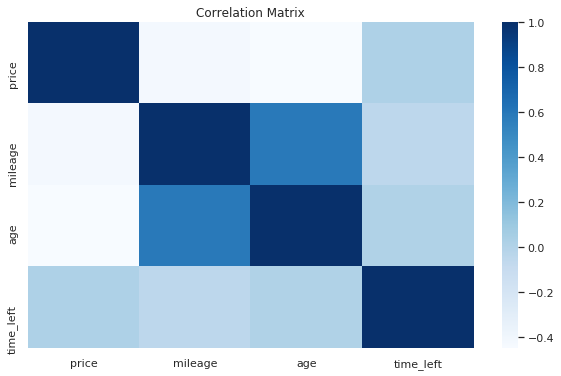

In [43]:
corr = df[['price','mileage','age', 'time_left']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='Blues').set_title('Correlation Matrix')

It seems like price is not correlated with time_left but there is significant negative correlation between price and age or mileage. This is expected because older cars are cheaper.

# **Data Preprocessing**

**Encoding**

We have categorical features such as brand and color. These features need to represented in a format that a model can process. We cannot just input strings in a model. We first need to convert the categories into numbers (**Label Encoding**). If a categorical variable is not ordinal (i.e. there is not a hierarchical order in them), it is not enough to just do label encoding. We need to represent the categories with binary columns. This can be done using "**dummy**" or "**one hot**" encoding. For example, we may “Dodge” label as 3 and “GMC” as 1. If we just do label encoding on not ordinal categorical variables, a model would think category 3 is somewhat more important than category 1 which is not true. One Hot Encoding represents each category as a column which only take two values, 1 and 0. For a car with “Dodge” brand, only the value in “Dodge” column becomes 1 and other columns are 0. In this way, we make sure there is not a hierarchy among categories.

**Normalization**

We also need to normalize the numerical data so that the values are in the same range. Otherwise, the model might give more importance to the higher values. For example, the values in mileage column are much higher than the values in age column. We can normalize these values in the range of [0,1] so that the maximum values for each column becomes 1 and the minimum becomes zero.

Since the categorical variables in our dataset are not ordinal, label encoding is not enough. Therefore, we can directly apply pandas get_dummies function to do represent categorical variables with columns assigned to each category.

In [44]:
dummy_variables = pd.get_dummies(df[['brand','model','title_status']], drop_first=True)

In [45]:
dummy_variables.shape

(2394, 57)

In [46]:
dummy_variables.head()

,brand_dodge,brand_ford,brand_gmc,brand_jeep,brand_nissan,brand_other,model_2500,model_altima,model_cab,model_camaro,...,model_suburban,model_tahoe,model_taurus,model_transit,model_traverse,model_trax,model_van,model_versa,model_wagon,title_status_salvage insurance
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We also need to normalize numerical variables.

In [47]:
num_features = df[['mileage', 'age', 'time_left', 'price']]

sc = MinMaxScaler()
num_features = sc.fit_transform(num_features)

num_features[:5]

NameError: name 'MinMaxScaler' is not defined

Now we need combine encoded categorical variables and normalized numerical variables to comprise the data that we will use in the model.

Than we separate target variable (price) from independent variables.

In [48]:
cat_features = dummy_variables.values
cat_features.shape

(2394, 57)

In [49]:
data = np.concatenate((cat_features, num_features), axis=1)

X = data[:, :data.shape[1]-1]
y = data[:, data.shape[1]-1]

print(X.shape)
print(y.shape)

(2394, 60)
(2394,)


**Traning and Test Sets**

In predictive analytics, we build machine learning models to make predictions on new, previously unseen samples. The whole purpose is to be able to predict the unknown. But the models cannot just make predictions out of the blue. We show some samples to the model and train it. Then we expect the model to make predictions on samples from the same distribution. In order to train the model and then test it, we need to divide the dataset into two subsets. One is training and the other one is test.

The separation of training and test set can easily be done using train_test_split function of scikit-learn.

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

We will use 80% of data in training and remaining 20% to test the model.

# **Building and Evaluating The Model**

I will implement two different models:

* Ridge Regression: A variation of linear regression with L2 regularization. Regularization adds penalty for higher terms in the model and thus controls the model complexity. If a regularization terms is added, the model tries to minimize both loss and complexity of model. Limiting the complexity prevents the model from overfitting.

* Gradient Boosting Regressor: An ensemble method that combines many decision trees using boosting. This is a more advance model than ridge regression.

# **Ridge regression**

In [51]:
from sklearn.linear_model import Ridge

In [52]:
ridge = Ridge(alpha=0.5)

#Train the model
ridge.fit(X_train, y_train)

#Evaluate the model
print('R-squared score (training): {:.3f}'
     .format(ridge.score(X_train, y_train)))

print('R-squared score (test): {:.3f}'
     .format(ridge.score(X_test, y_test)))

R-squared score (training): 0.625
R-squared score (test): 0.621


R-squared is a regression score function. It measures how much of the variation in the target variables is explained by the independent variables. The closer the R-squared value is to 1, the better the performance of model. R-squared scores of training and test sets are very close so the model is not overfitting. It seems like regularization works well. However, the performance of the model in terms of prediction power is not good enough because R-squared scores are not close to 1.

# **Gradient Boosting Regressor**

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

In [54]:
params = {'n_estimators': 600, 'max_depth': 5,
          'learning_rate': 0.02, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)

#Train the model
gbr.fit(X_train, y_train)

#Evaluate the model
print('R-squared score (training): {:.3f}'
     .format(gbr.score(X_train, y_train)))

print('R-squared score (test): {:.3f}'
     .format(gbr.score(X_test, y_test)))


R-squared score (training): 0.755
R-squared score (test): 0.701


As the results show, there is significant increase in R-squared score.

There is a slight difference between the values of training and test sets but I think this is acceptable with the data we have. We can create a model that has an R-squared value very close to 1 on training set but the performance on test set will be very low.

The main reason is the limited data. For complex models, we normally need lots of data to build a decent and robust model. The categorical variables in the dataset have many categories but not enough data for each category. Therefore, the first thing we should do to improve the model is to look for more data.

Another way to improve the performance is hyperparameter tuning. Hyperparameters define the properties of a model that we can adjust. For example, I tried different values for the following hyperparameters of gradient boosting regressor:

* n_estimators: The number of boosting stages to perform.
* max_depth: Maximum depth of the individual regression trees.
* learning_rate: The contribution of each tree is shrinked by the learning rate.

There is no strict rule to determine optimum values for these parameters. We need to find the right balance. Feel free to try different values for these parameters and see how the performance changes. Please do not limit yourself to what we did in exploratory data anaysis section. You can always dig deeper to explore the dataset to find out the correlations and underlying structure of data.